### Tensorboard setup
Tensorboard can be started with the following command:

tensorboard --logdir=/tmp/tensorflow/mnist/logs/fully_connected_feed

In [1]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Trains and Evaluates the MNIST network using a feed dictionary."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# pylint: disable=missing-docstring
import argparse
import os.path
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.examples.tutorials.mnist import mnist



In [2]:
# Basic model parameters as external flags.
FLAGS = None

In [3]:
if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument(
      '--learning_rate',
      type=float,
      default=0.01,
      help='Initial learning rate.'
  )
  parser.add_argument(
      '--max_steps',
      type=int,
      default=2000,
      help='Number of steps to run trainer.'
  )
  parser.add_argument(
      '--hidden1',
      type=int,
      default=128,
      help='Number of units in hidden layer 1.'
  )
  parser.add_argument(
      '--hidden2',
      type=int,
      default=32,
      help='Number of units in hidden layer 2.'
  )
  parser.add_argument(
      '--batch_size',
      type=int,
      default=100,
      help='Batch size.  Must divide evenly into the dataset sizes.'
  )
  parser.add_argument(
      '--input_data_dir',
      type=str,
      default='/tmp/tensorflow/mnist/input_data',
      help='Directory to put the input data.'
  )
  parser.add_argument(
      '--log_dir',
      type=str,
      default='/tmp/tensorflow/mnist/logs/fully_connected_feed',
      help='Directory to put the log data.'
  )
  

  FLAGS, unparsed = parser.parse_known_args()
  

In [4]:
FLAGS

Namespace(batch_size=100, hidden1=128, hidden2=32, input_data_dir='/tmp/tensorflow/mnist/input_data', learning_rate=0.01, log_dir='/tmp/tensorflow/mnist/logs/fully_connected_feed', max_steps=2000)

In [5]:
unparsed

['-f',
 '/run/user/1000/jupyter/kernel-63279b4a-0c3a-4b91-b898-b3683606d3a2.json']

In [6]:
def placeholder_inputs(batch_size):
  """Generate placeholder variables to represent the input tensors.

  These placeholders are used as inputs by the rest of the model building
  code and will be fed from the downloaded data in the .run() loop, below.

  Args:
    batch_size: The batch size will be baked into both placeholders.

  Returns:
    images_placeholder: Images placeholder.
    labels_placeholder: Labels placeholder.
  """
  # Note that the shapes of the placeholders match the shapes of the full
  # image and label tensors, except the first dimension is now batch_size
  # rather than the full size of the train or test data sets.
  images_placeholder = tf.placeholder(tf.float32, shape=(batch_size,
                                                             mnist.IMAGE_PIXELS), name = 'input_images')
        
    
  labels_placeholder = tf.placeholder(tf.int32, shape=(batch_size), name = 'output_labels')
  return images_placeholder, labels_placeholder


In [7]:
def fill_feed_dict(data_set, images_pl, labels_pl):
  """Fills the feed_dict for training the given step.

  A feed_dict takes the form of:
  feed_dict = {
      <placeholder>: <tensor of values to be passed for placeholder>,
      ....
  }

  Args:
    data_set: The set of images and labels, from input_data.read_data_sets()
    images_pl: The images placeholder, from placeholder_inputs().
    labels_pl: The labels placeholder, from placeholder_inputs().

  Returns:
    feed_dict: The feed dictionary mapping from placeholders to values.
  """
  # Create the feed_dict for the placeholders filled with the next
  # `batch size` examples.
  images_feed, labels_feed = data_set.next_batch(FLAGS.batch_size)
  feed_dict = {
      images_pl: images_feed,
      labels_pl: labels_feed,
  }
  return feed_dict

In [8]:
def do_eval(sess,
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_set):
  """Runs one evaluation against the full epoch of data.

  Args:
    sess: The session in which the model has been trained.
    eval_correct: The Tensor that returns the number of correct predictions.
    images_placeholder: The images placeholder.
    labels_placeholder: The labels placeholder.
    data_set: The set of images and labels to evaluate, from
      input_data.read_data_sets().
  """
  # And run one epoch of eval.
  true_count = 0  # Counts the number of correct predictions.
  steps_per_epoch = data_set.num_examples // FLAGS.batch_size
  num_examples = steps_per_epoch * FLAGS.batch_size
  for step in xrange(steps_per_epoch):
    feed_dict = fill_feed_dict(data_set,
                               images_placeholder,
                               labels_placeholder)
    true_count += sess.run(eval_correct, feed_dict=feed_dict)
  precision = float(true_count) / num_examples
  print('  Num examples: %d  Num correct: %d  Precision @ 1: %0.04f' %
        (num_examples, true_count, precision))



In [9]:
if tf.gfile.Exists(FLAGS.log_dir):
    tf.gfile.DeleteRecursively(FLAGS.log_dir)
tf.gfile.MakeDirs(FLAGS.log_dir)


In [10]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def


def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [11]:
"""Train MNIST for a number of steps."""
# Get the sets of images and labels for training, validation, and
# test on MNIST.
data_sets = input_data.read_data_sets(FLAGS.input_data_dir)


Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


In [12]:
pixels, labels = data_sets.train.next_batch(10)

In [13]:
example_to_show=5

In [14]:
imagevec = pixels[example_to_show,:]

In [15]:
image = np.reshape(imagevec,[28, 28])

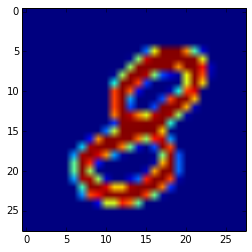

In [16]:
%matplotlib inline
plt.imshow(image)
plt.show()

In [17]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.InteractiveSession()

In [18]:
manager=tf.Graph().as_default()

In [19]:
manager.__enter__()

In [20]:
images_placeholder, labels_placeholder = placeholder_inputs(
    FLAGS.batch_size)

In [21]:
show_graph(tf.get_default_graph().as_graph_def())

In [22]:
# Build a Graph that computes predictions from the inference model.
with tf.name_scope('model_prediction'):
    model_prediction = mnist.inference(images_placeholder,
                             FLAGS.hidden1,
                             FLAGS.hidden2)

In [23]:
show_graph(tf.get_default_graph().as_graph_def())

In [24]:
# Add to the Graph the Ops for loss calculation.
with tf.name_scope('loss'):
    loss = mnist.loss(model_prediction, labels_placeholder)

In [25]:
show_graph(tf.get_default_graph().as_graph_def())

In [26]:
# Add to the Graph the Ops that calculate and apply gradients.
with tf.name_scope('train_op'):
    train_op = mnist.training(loss, FLAGS.learning_rate)

In [27]:
show_graph(tf.get_default_graph().as_graph_def())

In [28]:
# Add the Op to compare the logits to the labels during evaluation.
with tf.name_scope('eval_correct'):
    eval_correct = mnist.evaluation(model_prediction, labels_placeholder)

In [29]:
show_graph(tf.get_default_graph().as_graph_def())

In [30]:
# Build the summary Tensor based on the TF collection of Summaries.
summary = tf.summary.merge_all()

# Add the variable initializer Op.
init = tf.global_variables_initializer()

In [31]:
show_graph(tf.get_default_graph().as_graph_def())

In [32]:
# Create a saver for writing training checkpoints.
saver = tf.train.Saver()

In [33]:
show_graph(tf.get_default_graph().as_graph_def())

In [34]:
# Create a session for running Ops on the Graph.
sess = tf.InteractiveSession()


# Instantiate a SummaryWriter to output summaries and the Graph.
summary_writer = tf.summary.FileWriter(FLAGS.log_dir, sess.graph)

# And then after everything is built:

# Run the Op to initialize the variables.
sess.run(init)

In [35]:
# Start the training loop.
for step in xrange(FLAGS.max_steps):
  start_time = time.time()

  # Fill a feed dictionary with the actual set of images and labels
  # put the next batch of data into feed_dict
  # for this particular training step.
  feed_dict = fill_feed_dict(data_sets.train,
                             images_placeholder,
                             labels_placeholder)

   
  # Run one step of the model.  The return values are the activations
  # from the `train_op` (which is discarded) and the `loss` Op.  To
  # inspect the values of your Ops or variables, you may include them
  # in the list passed to sess.run() and the value tensors will be
  # returned in the tuple from the call.
  _, loss_value = sess.run([train_op, loss],
                           feed_dict=feed_dict)

  duration = time.time() - start_time

  # Write the summaries and print an overview fairly often.
  if step % 100 == 0:
    # Print status to stdout.
    print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
    # Update the events file.
    summary_str = sess.run(summary, feed_dict=feed_dict)
    summary_writer.add_summary(summary_str, step)
    summary_writer.flush()

  # Save a checkpoint and evaluate the model periodically.
  if (step + 1) % 1000 == 0 or (step + 1) == FLAGS.max_steps:
    checkpoint_file = os.path.join(FLAGS.log_dir, 'model.ckpt')
    saver.save(sess, checkpoint_file, global_step=step)
    # Evaluate against the training set.
    print('Training Data Eval:')
    do_eval(sess,
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_sets.train)
    # Evaluate against the validation set.
    print('Validation Data Eval:')
    do_eval(sess,
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_sets.validation)
    # Evaluate against the test set.
    print('Test Data Eval:')
    do_eval(sess,
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_sets.test)


Step 0: loss = 2.33 (0.153 sec)
Step 100: loss = 2.13 (0.001 sec)
Step 200: loss = 1.83 (0.001 sec)
Step 300: loss = 1.47 (0.001 sec)
Step 400: loss = 1.22 (0.001 sec)
Step 500: loss = 0.78 (0.001 sec)
Step 600: loss = 0.83 (0.001 sec)
Step 700: loss = 0.68 (0.001 sec)
Step 800: loss = 0.66 (0.001 sec)
Step 900: loss = 0.43 (0.001 sec)
Training Data Eval:
  Num examples: 55000  Num correct: 47861  Precision @ 1: 0.8702
Validation Data Eval:
  Num examples: 5000  Num correct: 4386  Precision @ 1: 0.8772
Test Data Eval:
  Num examples: 10000  Num correct: 8805  Precision @ 1: 0.8805
Step 1000: loss = 0.43 (0.001 sec)
Step 1100: loss = 0.54 (0.001 sec)
Step 1200: loss = 0.57 (0.001 sec)
Step 1300: loss = 0.52 (0.001 sec)
Step 1400: loss = 0.54 (0.001 sec)
Step 1500: loss = 0.34 (0.001 sec)
Step 1600: loss = 0.38 (0.001 sec)
Step 1700: loss = 0.33 (0.001 sec)
Step 1800: loss = 0.36 (0.001 sec)
Step 1900: loss = 0.48 (0.001 sec)
Training Data Eval:
  Num examples: 55000  Num correct: 49346 

In [ ]:
show_graph(tf.get_default_graph().as_graph_def())